<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/sequence_modelling/text_generation_rnn/Text_Generation_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🛠️ Install and import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import requests
import random
import numpy as np

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [2]:
# 📚 Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

print(f"Length of text: {len(text)} characters")
print("Sample text:", text[:500])


Length of text: 1115394 characters
Sample text: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
# 🔤 Preprocessing - character mappings
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocab size: {vocab_size}")

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])


Vocab size: 65


In [4]:
# 📦 Prepare the dataset
data = torch.tensor(encode(text), dtype=torch.long)

# Train/Validation split
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loader
def get_batch(split, batch_size, block_size):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [5]:
# 🧠 Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden

model = LSTMModel(vocab_size, embed_size=128, hidden_size=256).to(device)

In [6]:
# ⚙️ Training setup
batch_size = 64
block_size = 128
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
losses = []


In [7]:
# 🚀 Training loop
for iter in range(max_iters):
    model.train()
    xb, yb = get_batch('train', batch_size, block_size)

    logits, _ = model(xb)
    logits = logits.view(-1, vocab_size)
    yb = yb.view(-1)

    loss = criterion(logits, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % eval_interval == 0:
        model.eval()
        with torch.no_grad():
            val_xb, val_yb = get_batch('val', batch_size, block_size)
            val_logits, _ = model(val_xb)
            val_logits = val_logits.view(-1, vocab_size)
            val_yb = val_yb.view(-1)
            val_loss = criterion(val_logits, val_yb)

        print(f"Step {iter}: Train Loss {loss.item():.4f}, Val Loss {val_loss.item():.4f}")
        losses.append((iter, loss.item(), val_loss.item()))


Step 0: Train Loss 4.1828, Val Loss 4.1329
Step 300: Train Loss 1.8343, Val Loss 1.9421
Step 600: Train Loss 1.5716, Val Loss 1.7418
Step 900: Train Loss 1.4828, Val Loss 1.6503
Step 1200: Train Loss 1.5028, Val Loss 1.6486
Step 1500: Train Loss 1.3772, Val Loss 1.5978
Step 1800: Train Loss 1.3671, Val Loss 1.5839
Step 2100: Train Loss 1.3808, Val Loss 1.6068
Step 2400: Train Loss 1.3409, Val Loss 1.5427
Step 2700: Train Loss 1.2982, Val Loss 1.5516


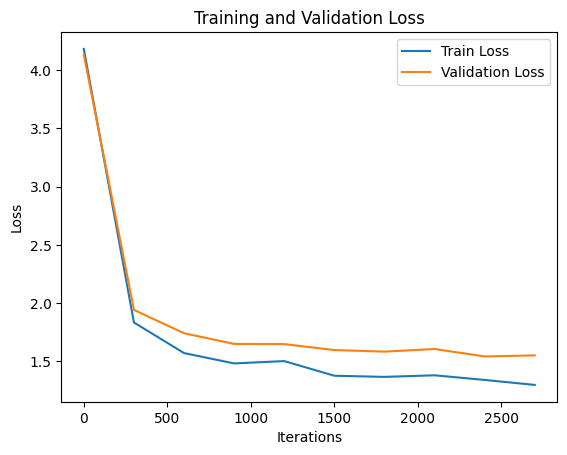

In [8]:
# 📈 Plot training and validation loss
iters, train_losses, val_losses = zip(*losses)
plt.plot(iters, train_losses, label="Train Loss")
plt.plot(iters, val_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [9]:
# ✨ Text generation function
def generate_text(model, start_text, length=500, temperature=1.0):
    model.eval()
    input_ids = torch.tensor(encode(start_text), dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    generated = start_text

    for _ in range(length):
        logits, hidden = model(input_ids, hidden)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        next_char = decode(next_id.view(-1).tolist())
        generated += next_char
        input_ids = next_id

    return generated


In [10]:
# 🎉 Generate new text!
start_text = "ROMEO:"
generated_text = generate_text(model, start_text, length=1000, temperature=0.8)
print(generated_text)


ROMEO:
You have a many words, like a need, a stand in
The fly so seen and deposed himself.

KING HENRY VI:
And thou would hath slain to let me prevented your words;
And, lords, I shall fell I'll tell thee, as I would not pardon
The curse it.

LADY CAPULET:
My liege; I would my good love, your daughter?

QUEEN ELIZABETH:
Fareweelly; and all to thee to speak.

PRINCE EDWARD:
Why, when she good upon my brothers,
Thereof what this which you will have some infection
Which I wast to does peeper, the duke have
For the people prosperty, you shall a
curse of reasonous man against thee with the sun of this:
And yet you have to be revenerate as she stay'd.
Being them not this tabby with her.

SICINIUS:
Be thou condains, the heavens' keel themselves?
Imand more than the two limpting Henry's death
Dare still as in the common judgments of a free
After him steeps of now's virgee, and your done.
But that I shall know the sovereign at the weet
To fled to save the fire of Ancher, wholese
That doth 'twer